## Access ANMN CTD Mooring NRT data in Parquet

A jupyter notebook to show how to access and plot ANMN Mooring NRT data available as a [Parquet](https://parquet.apache.org) dataset on S3.

More information about the dataset available at [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/7b901002-b1dc-46c3-89f2-b4951cedca48).

In [1]:
dataset_name = "mooring_ctd_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    import xarray as xr
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 26ms


In [3]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

## Location of the parquet dataset

In [5]:
BUCKET_OPTIMISED_DEFAULT="imos-data-lab-optimised"
dname = f"s3://{BUCKET_OPTIMISED_DEFAULT}/cloud_optimised/cluster_testing/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [6]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

site_code: string
timestamp: int32
polygon: string


## List unique partition values

In [7]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'site_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['PIL200', 'VBM100']
CPU times: user 5.1 ms, sys: 1.04 ms, total: 6.15 ms
Wall time: 5.42 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/DataQuery.py:486: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


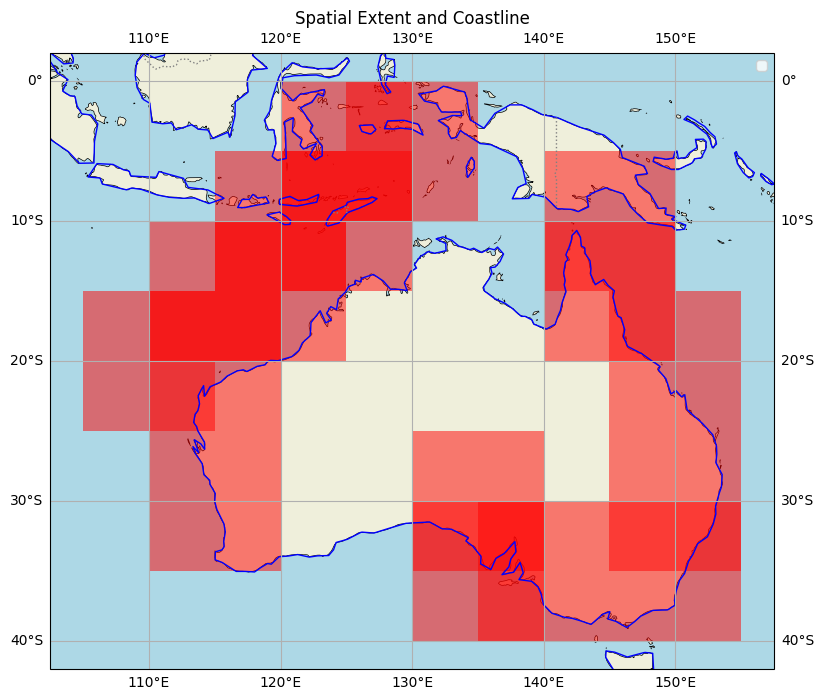

In [8]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [9]:
get_temporal_extent(parquet_ds)

(Timestamp('2008-05-04 23:00:00.999997952'),
 Timestamp('2024-07-15 06:30:00.999997952'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [10]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'TIME': {'type': 'timestamp[ns]',
  'axis': 'T',
  'comment': 'timeOffsetPP: TIME values and time_coverage_start/end global attributes have been applied the following offset : -10 hours.',
  'long_name': 'time',
  'standard_name': 'time',
  'valid_max': 90000.0,
  'valid_min': 0.0},
 'TIMESERIES': {'type': 'int32',
  'cf_role': 'timeseries_id',
  'long_name': 'unique_identifier_for_each_timeseries_feature_instance_in_this_file'},
 'LATITUDE': {'type': 'double',
  'axis': 'Y',
  'long_name': 'latitude',
  'reference_datum': 'WGS84 geographic coordinate system',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'valid_max': 90.0,
  'valid_min': -90.0},
 'LONGITUDE': {'type': 'double',
  'axis': 'X',
  'long_name': 'longitude',
  'reference_datum': 'WGS84 geographic coordinate system',
  'standard_name': 'longitude',
  'units': 'degrees_east',
  'valid_max': 180.0,
  'valid_min': -180.0},
 'NOMINAL_DEPTH': {'type': 'float',
  'axis': 'Z',
  'long_name': 'nominal depth',
  'pos

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [11]:
filter_time = create_time_filter(parquet_ds, date_start='2022-12-05', date_end='2022-12-15')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)


filter = filter_geo & filter_time

In [12]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23040 entries, 0 to 23039
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TIME                      23040 non-null  datetime64[ns]
 1   TIMESERIES                23040 non-null  int32         
 2   LATITUDE                  23040 non-null  float64       
 3   LONGITUDE                 23040 non-null  float64       
 4   NOMINAL_DEPTH             23040 non-null  float32       
 5   CNDC                      23040 non-null  float32       
 6   CNDC_quality_control      23040 non-null  float32       
 7   TEMP                      23040 non-null  float32       
 8   TEMP_quality_control      23040 non-null  float32       
 9   PSAL                      23040 non-null  float32       
 10  PSAL_quality_control      23040 non-null  float32       
 11  PRES_REL                  23040 non-null  float32       
 12  PRES_REL_quality_c

## Create a TIME and scalar/number filter

In [13]:
filter_time = create_time_filter(parquet_ds, date_start='2022-12-05', date_end='2022-12-15')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-28, lon_min=151, lon_max=160)

expr_1 = pc.field('site_code') == pa.scalar("CH100")
filter = expr_1 & filter_time & filter_geo

In [14]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   TIME                      5760 non-null   datetime64[ns]
 1   TIMESERIES                5760 non-null   int32         
 2   LATITUDE                  5760 non-null   float64       
 3   LONGITUDE                 5760 non-null   float64       
 4   NOMINAL_DEPTH             5760 non-null   float32       
 5   CNDC                      5760 non-null   float32       
 6   CNDC_quality_control      5760 non-null   float32       
 7   TEMP                      5760 non-null   float32       
 8   TEMP_quality_control      5760 non-null   float32       
 9   PSAL                      5760 non-null   float32       
 10  PSAL_quality_control      5760 non-null   float32       
 11  PRES_REL                  5760 non-null   float32       
 12  PRES_REL_quality_con

In [15]:
df[df['NOMINAL_DEPTH'] == 9]['site_code'].unique()

['CH100']
Categories (40, object): ['BMP070', 'BMP120', 'CAM050', 'CAM100', ..., 'VBM100', 'WACA20', 'WATR10', 'WATR20']

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

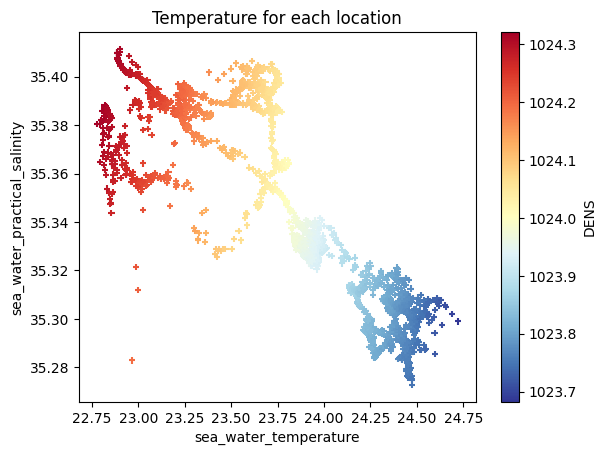

In [16]:
df[(df['NOMINAL_DEPTH'] == 9) & (df['site_code']=='CH100')].plot.scatter(x='TEMP', y='PSAL', 
                                                                         c='DENS', marker='+', linestyle="None", cmap='RdYlBu_r', 
                                                                         title='Temperature for each location',
                                                                         ylabel=metadata['PSAL']['standard_name'],
                                                                         xlabel=metadata['TEMP']['standard_name'])

<Axes: xlabel='TIME', ylabel='sea_water_temperature'>

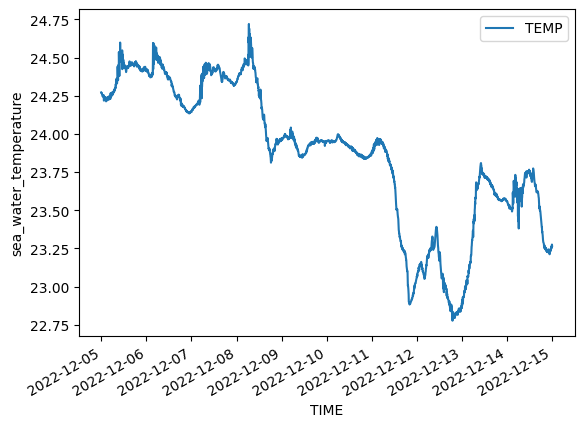

In [17]:
df[(df['NOMINAL_DEPTH'] == 9) & (df['site_code']=='CH100')].sort_values('TIME').plot(y='TEMP', x='TIME',
                                                                                     ylabel=metadata['TEMP']['standard_name'])

## Plot TS diagram - compare with quality control values

### Example A

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

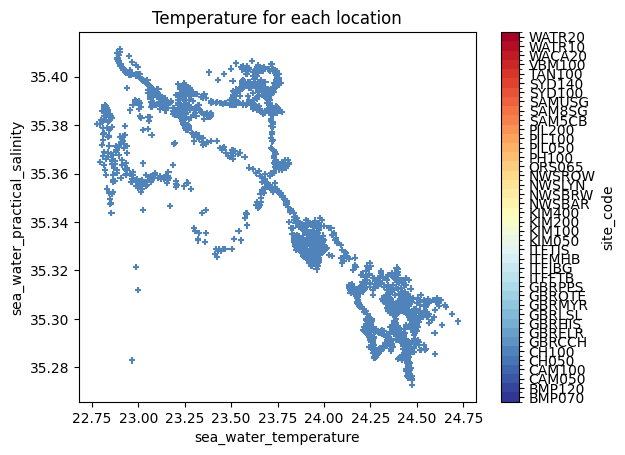

In [18]:
df[(df['NOMINAL_DEPTH'] <= 20) ].plot.scatter(x='TEMP', y='PSAL', c='site_code', 
                                              marker='+', linestyle="None", cmap='RdYlBu_r', 
                                              title='Temperature for each location',
                                              ylabel=metadata['PSAL']['standard_name'],
                                              xlabel=metadata['TEMP']['standard_name'])

<Axes: title={'center': 'Temperature for each location'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

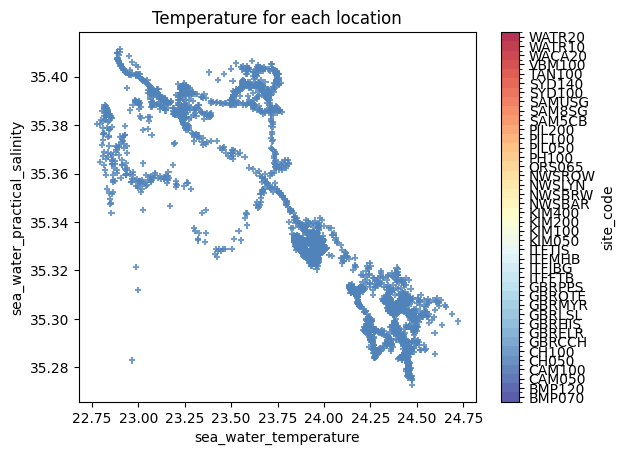

In [19]:
df[(df['NOMINAL_DEPTH'] <= 20) & (df['PSAL_quality_control'] == 1) ].plot.scatter(x='TEMP', y='PSAL', c='site_code', 
                                                                                  marker='+', linestyle="None", cmap='RdYlBu_r', 
                                                                                  alpha=0.8, title='Temperature for each location',
                                                                                  ylabel=metadata['PSAL']['standard_name'],
                                                                                  xlabel=metadata['TEMP']['standard_name'])

## Example B

<Axes: title={'center': 'TS at CH100 at various nominal depths'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

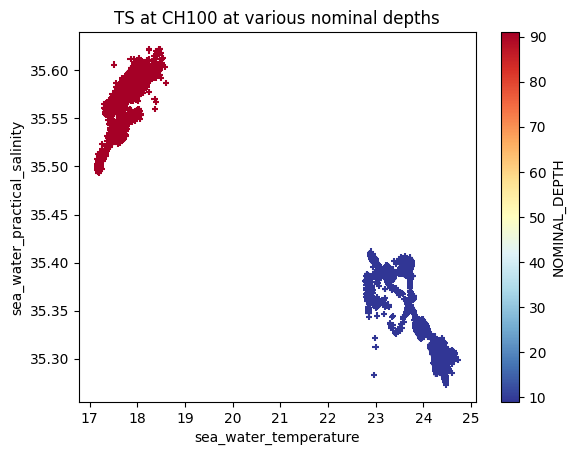

In [20]:
df[(df['site_code']=='CH100')].plot.scatter(x='TEMP', y='PSAL', c='NOMINAL_DEPTH', 
                                            marker='+', linestyle="None", cmap='RdYlBu_r', 
                                            title='TS at CH100 at various nominal depths',
                                              ylabel=metadata['PSAL']['standard_name'],
                                              xlabel=metadata['TEMP']['standard_name'])

<Axes: title={'center': 'TS at CH100 at various nominal depths'}, xlabel='sea_water_temperature', ylabel='sea_water_practical_salinity'>

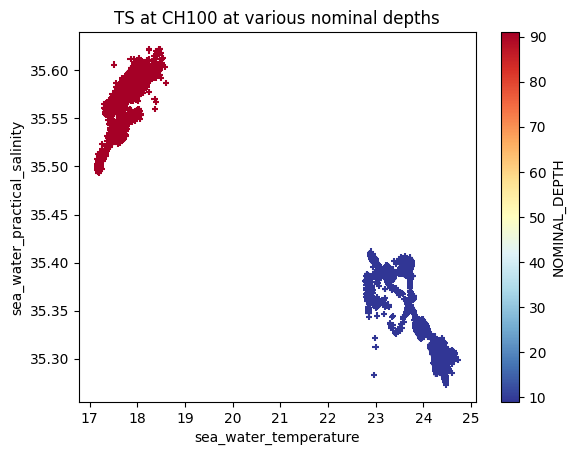

In [21]:
df[(df['site_code']=='CH100') & (df['PSAL_quality_control'] == 1)].plot.scatter(x='TEMP', y='PSAL', 
                                                                                c='NOMINAL_DEPTH', marker='+', linestyle="None", 
                                                                                cmap='RdYlBu_r', 
                                                                                title='TS at CH100 at various nominal depths',
                                                                                ylabel=metadata['PSAL']['standard_name'],
                                                                                xlabel=metadata['TEMP']['standard_name'])